In [1]:
import requests
import pandas as pd
import numpy as np
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'
count = 1000
pages = 100

In [3]:
results = []
params = {'$limit': count, '$offset': 0}

for i in range(0, pages):
    
    try:
        r = requests.get(endpoint, params=params)
        results.append(r.json())
        params['$offset'] = count
        count += 1000
        
    except HTTPError as err:
        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

len(results)

100

In [4]:
outcome_df = pd.DataFrame()

for i in results:
    outcome_df = outcome_df.append(pd.io.json.json_normalize(i))

len(outcome_df)

100000

In [5]:
cats_df = outcome_df[outcome_df['animal_type'] == 'Cat'].reset_index()
del cats_df['index']

In [6]:
print(len(cats_df))
cats_df.head()

37487


,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,4 months,A818492,Cat,Domestic Medium Hair,Black,2020-02-09T00:00:00.000,2020-06-19T17:13:00.000,2020-06-19T17:13:00.000,*Virgo,Partner,Transfer,Neutered Male
1,4 months,A818489,Cat,Domestic Medium Hair,Black,2020-02-09T00:00:00.000,2020-06-19T17:13:00.000,2020-06-19T17:13:00.000,*Capricorn,Partner,Transfer,Neutered Male
2,7 months,A818666,Cat,Domestic Medium Hair,Orange Tabby,2019-11-12T00:00:00.000,2020-06-19T17:12:00.000,2020-06-19T17:12:00.000,*Paul,Partner,Transfer,Neutered Male
3,4 months,A818695,Cat,Domestic Shorthair,Brown Tabby,2020-01-28T00:00:00.000,2020-06-19T17:12:00.000,2020-06-19T17:12:00.000,*Brogan,Partner,Transfer,Neutered Male
4,7 months,A818664,Cat,Domestic Medium Hair,Orange Tabby,2019-11-12T00:00:00.000,2020-06-19T17:12:00.000,2020-06-19T17:12:00.000,*Peter,Partner,Transfer,Neutered Male


In [7]:
outcome_df.to_csv('data/aac_outcomes_working.csv', index=False, encoding='utf-8')
cats_df.to_csv('data/cats_working.csv', index=False, encoding='utf-8')

## Featuring Enginering 

In [8]:
cats_df['count'] = 1

In [9]:
cats_df['sex'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 'Male', 'Female')
cats_df['Spay/Neuter'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 'No', 'Yes')

In [10]:
cats_df['age_upon_outcome'].head()

0    4 months
1    4 months
2    7 months
3    4 months
4    7 months
Name: age_upon_outcome, dtype: object

In [11]:
cats_df = cats_df[cats_df['age_upon_outcome'] != 'NULL']
cats_df['Periods'], cats_df['Period Range'] = cats_df['age_upon_outcome'].str.split(' ').str[0].fillna(0).astype(int), cats_df['age_upon_outcome'].str.split(' ').str[1].fillna(0)

In [12]:
cats_df['Period Range'].unique()

array(['months', 'years', 'weeks', 'month', 'week', 'year', 'days', 'day'],
      dtype=object)

In [13]:
cats_df['Period Range'] = np.where(cats_df['Period Range'].str.contains('day'), 1, 
                                   np.where(cats_df['Period Range'].str.contains('week'), 7, 
                                            np.where(cats_df['Period Range'].str.contains('month'), 30, 
                                                     np.where(cats_df['Period Range'].str.contains('year'), 365, 0)))).astype(int)

cats_df['outcome_age_(days)'] = cats_df['Period Range'] * cats_df['Periods']
cats_df['outcome_age_(years)'] = cats_df['outcome_age_(days)'] / 365

In [14]:
cats_df['Cat/Kitten (outcome)'] = np.where(cats_df['outcome_age_(days)'] >= 180, 'Cat', 'Kitten')
cats_df['sex_age_outcome'] = cats_df['sex_upon_outcome'] + ' ' + cats_df['Cat/Kitten (outcome)']

In [15]:
cats_df['age_group'] = pd.cut(cats_df['outcome_age_(years)'], 10)
cats_df['age_group'].value_counts()

(-0.022, 2.2]    32055
(2.2, 4.4]        1833
(4.4, 6.6]        1135
(6.6, 8.8]         917
(8.8, 11.0]        840
(11.0, 13.2]       396
(13.2, 15.4]       196
(15.4, 17.6]        73
(17.6, 19.8]        26
(19.8, 22.0]        14
Name: age_group, dtype: int64

In [16]:
cats_df['date_of_birth'] = pd.to_datetime(cats_df['date_of_birth'])

cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(cats_df['monthyear']).dt.to_period('M')

cats_df['datetime'] = pd.to_datetime(cats_df['datetime'])
cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday_name
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour

In [17]:
cats_df['breed'].value_counts()

Domestic Shorthair Mix                      25535
Domestic Shorthair                           5232
Domestic Medium Hair Mix                     2546
Domestic Longhair Mix                        1201
Siamese Mix                                  1050
Domestic Medium Hair                          634
American Shorthair Mix                        220
Siamese                                       173
Domestic Longhair                             173
Snowshoe Mix                                  126
Maine Coon Mix                                 85
Manx Mix                                       63
Russian Blue Mix                               47
Ragdoll Mix                                    39
American Shorthair                             33
Himalayan Mix                                  31
Persian Mix                                    17
Maine Coon                                     17
Balinese Mix                                   15
Russian Blue                                   14


In [18]:
cats_df['breed'] = cats_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [19]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [20]:
cats_df = pd.concat([cats_df, 
                     cats_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

cats_df['cfa_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds)) | 
                                (cats_df['breed2'].str.contains(cfa_breeds)), 
                                True, False)

cats_df['domestic_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds) == False) | 
                                     (cats_df['breed2'].str.contains(cfa_breeds) == False), 
                                     True, False)

In [21]:
cats_df['color'].value_counts()

Brown Tabby                  5652
Black                        4964
Black/White                  3468
Brown Tabby/White            2938
Orange Tabby                 2787
Tortie                       1758
Calico                       1672
Blue Tabby                   1406
Blue                         1388
Orange Tabby/White           1340
Torbie                       1077
Blue/White                   1012
Blue Tabby/White              695
White/Black                   656
Cream Tabby                   620
Lynx Point                    484
White/Brown Tabby             405
Seal Point                    383
White                         378
Cream Tabby/White             304
Gray Tabby                    270
Torbie/White                  238
White/Blue                    238
Flame Point                   227
Black Tabby                   190
Gray Tabby/White              147
White/Orange Tabby            131
Black Smoke                   114
Gray/White                    110
Orange/White  

In [22]:
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

In [23]:
# Create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

In [24]:
cats_df['color'] = cats_df['color'].str.lower()

cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)

cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

In [25]:
cats_df = pd.concat([cats_df, 
                     cats_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

cats_df['color1'] = np.where(cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])

cats_df['coat'] = np.where(cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])

In [26]:
cats_df.to_csv('data/cats_df_clean.csv', index=False, encoding='utf-8')

In [27]:
cats_df = pd.read_csv('data/cats_df_clean.csv')

In [28]:
sns.set(font_scale=1.7, palette=sns.color_palette("Set1", n_colors=15, desat=.5)) #sns.xkcd_palette(sns.xkcd_rgb))
sns.set_style('ticks')

C:\Users\Diogo\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Diogo\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


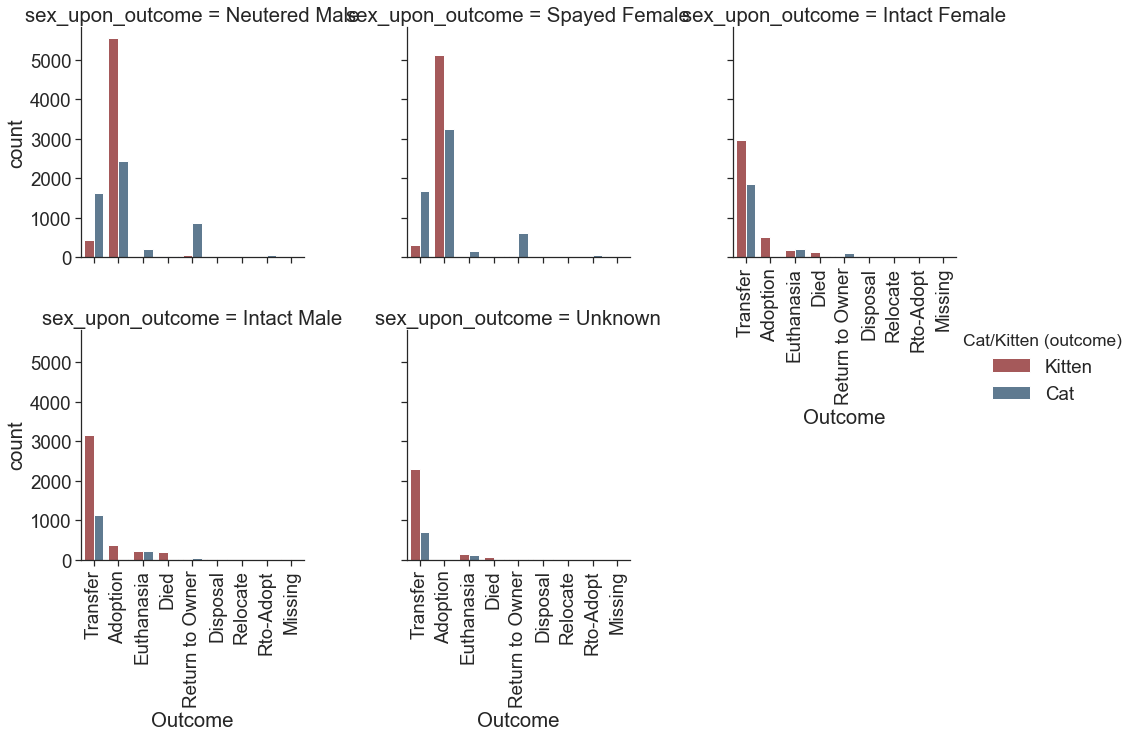

In [29]:
g = sns.factorplot(x='outcome_type', hue='Cat/Kitten (outcome)', col='sex_upon_outcome', 
               col_wrap=3, data=cats_df, kind='count', size=4.5)

g.set_xticklabels(rotation=90)
g.set_xlabels('Outcome')

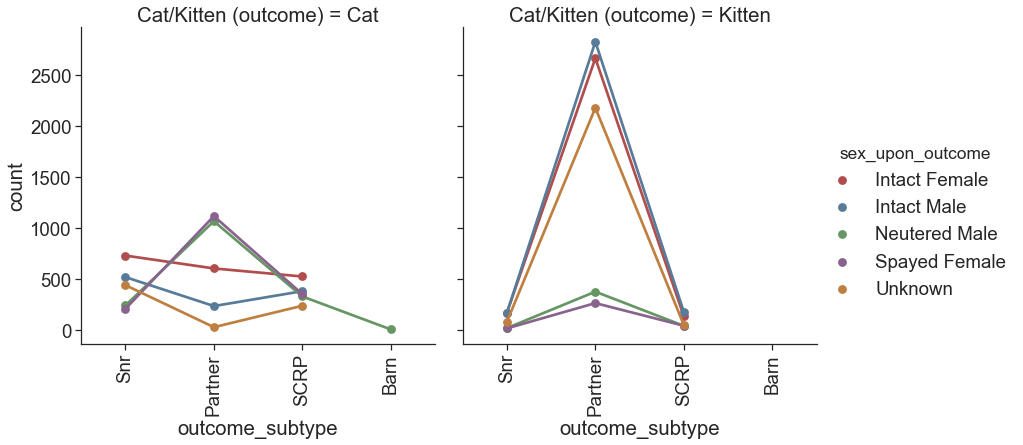

In [30]:
transfer_subtype_counts = cats_df[cats_df['outcome_type'] == 'Transfer']
transfer_subtype_counts = transfer_subtype_counts.groupby(['sex_upon_outcome', 'Cat/Kitten (outcome)'])['outcome_subtype'].value_counts().reset_index(name='count')

g = sns.factorplot(x='outcome_subtype', y='count', hue='sex_upon_outcome', col='Cat/Kitten (outcome)', 
               data=transfer_subtype_counts, size=6)

g.set_xticklabels(rotation=90)

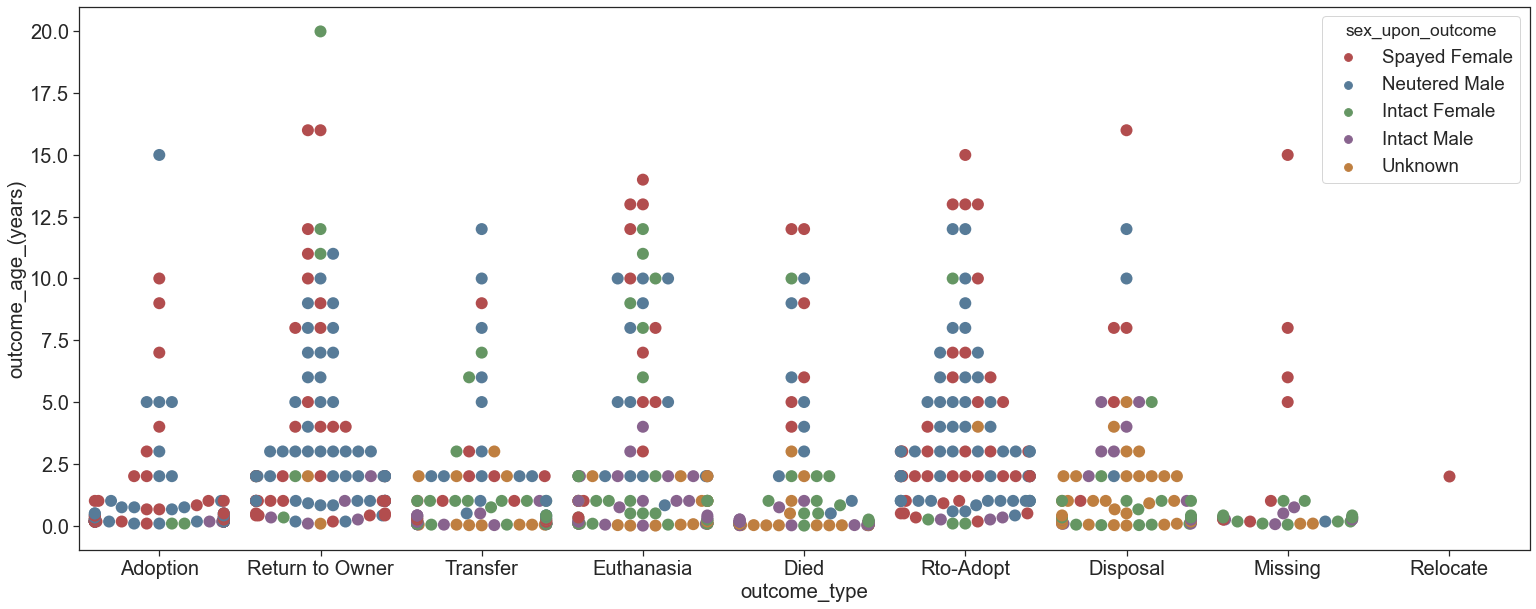

In [31]:
cat_outcomes_sample = cats_df.sample(frac=1.0).groupby(['outcome_type']).head(100)

plt.figure(figsize=(26,10))
g = sns.swarmplot(x='outcome_type', y='outcome_age_(years)', hue='sex_upon_outcome', 
                  data=cat_outcomes_sample, size=12)

g.tick_params(labelsize=20)

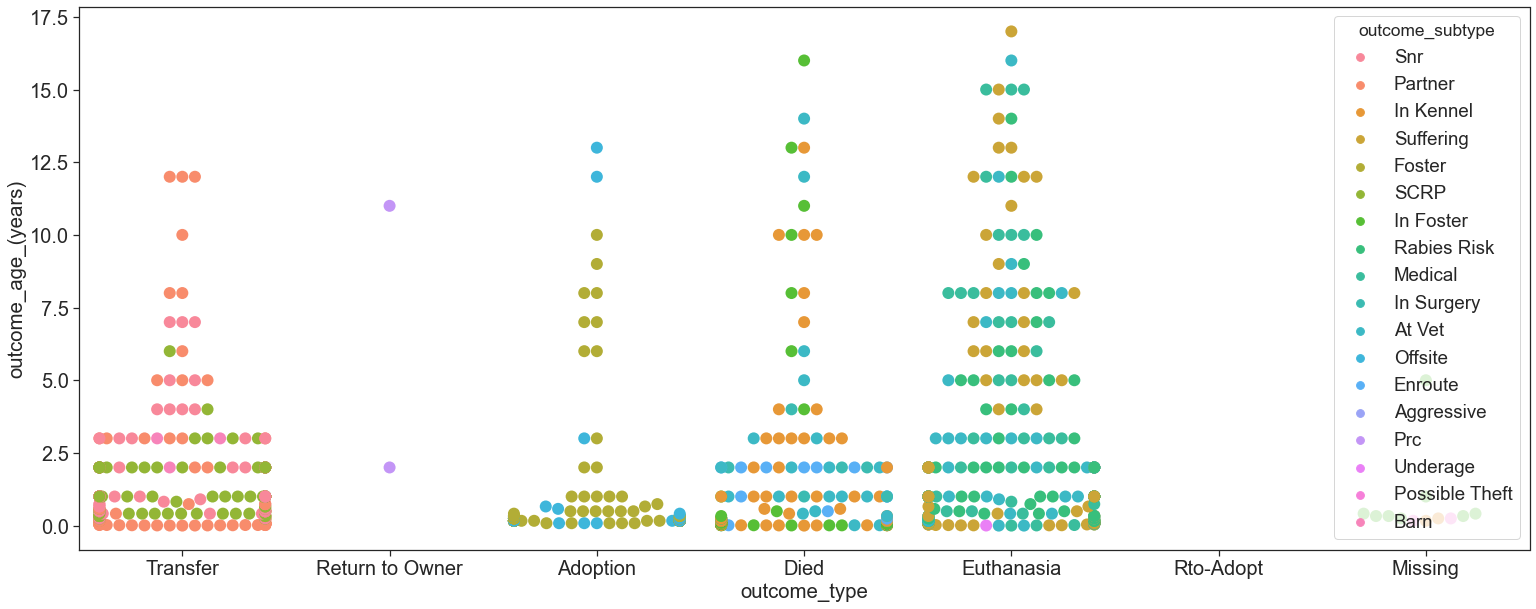

In [32]:
cat_suboutcomes_sample = cats_df.sample(frac=1.0).groupby(['outcome_subtype']).head(100)

plt.figure(figsize=(26,10))
g = sns.swarmplot(x='outcome_type', y='outcome_age_(years)', hue='outcome_subtype', 
                  data=cat_suboutcomes_sample, size=12)

g.tick_params(labelsize=20)

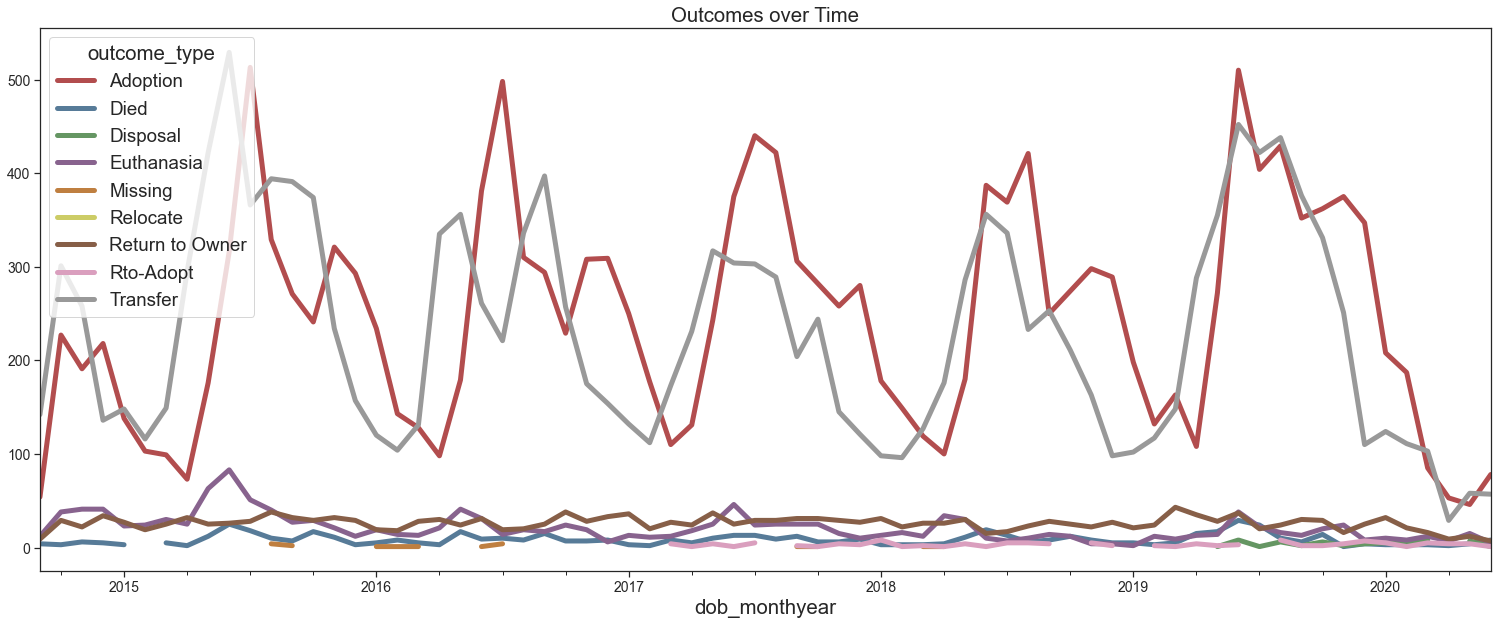

In [33]:
monthyear_outcomes = pd.pivot_table(cats_df, index=['dob_monthyear'], 
                                    columns=['outcome_type'], values='count', aggfunc=np.sum)
monthyear_outcomes.index = pd.to_datetime(monthyear_outcomes.index)

monthyear_outcomes.plot(fontsize=14, linewidth=5, title='Outcomes over Time', figsize=(26,10))

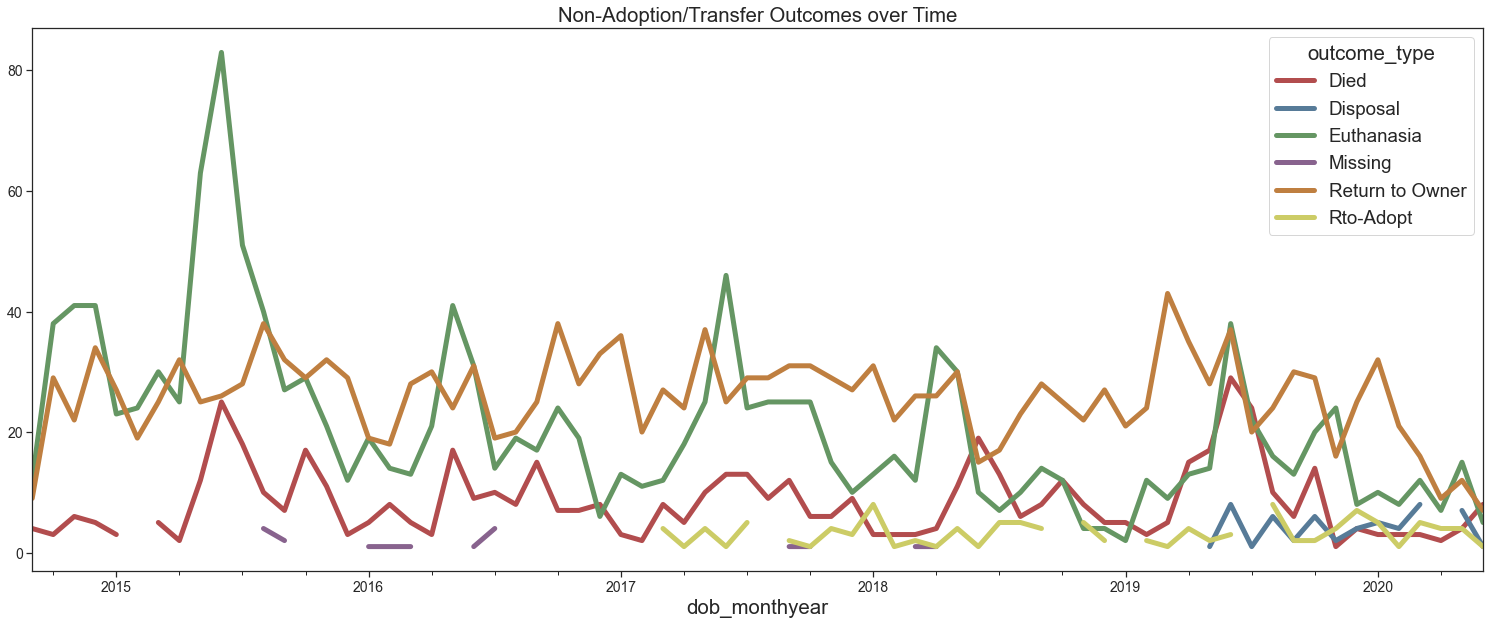

In [34]:
monthyear_outcomes2 = monthyear_outcomes.filter(items=['Died', 'Disposal', 'Euthanasia', 'Missing', 
                                                      'Return to Owner', 'Rto-Adopt'])

monthyear_outcomes2.plot(fontsize=14, linewidth=5, figsize=(26,10), 
                         title='Non-Adoption/Transfer Outcomes over Time')

C:\Users\Diogo\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Diogo\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


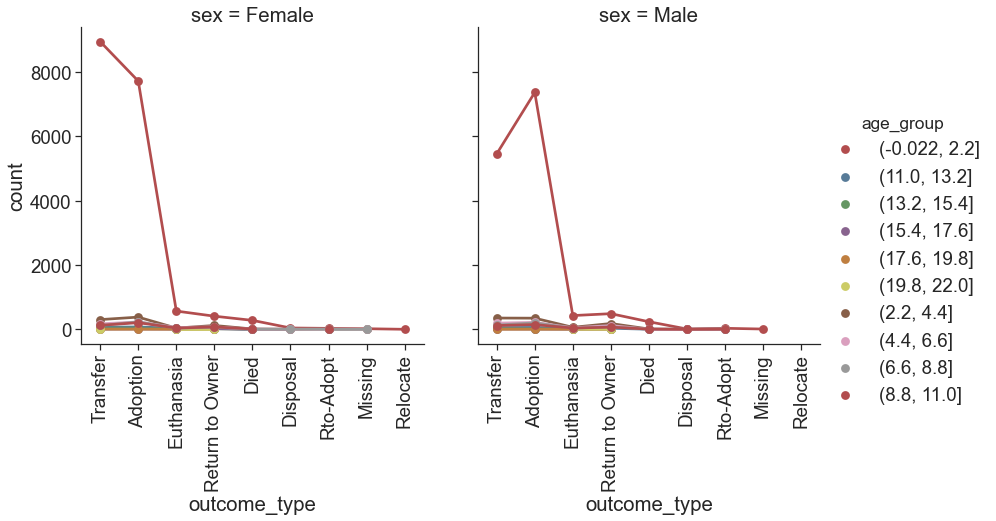

In [35]:
agegroup_counts = cats_df.groupby(['age_group', 'sex'])['outcome_type'].value_counts().reset_index(name='count')

g = sns.factorplot(x='outcome_type', y='count', hue='age_group', col='sex',
                   data=agegroup_counts, size=6)

g.set_xticklabels(rotation=90)

C:\Users\Diogo\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Diogo\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


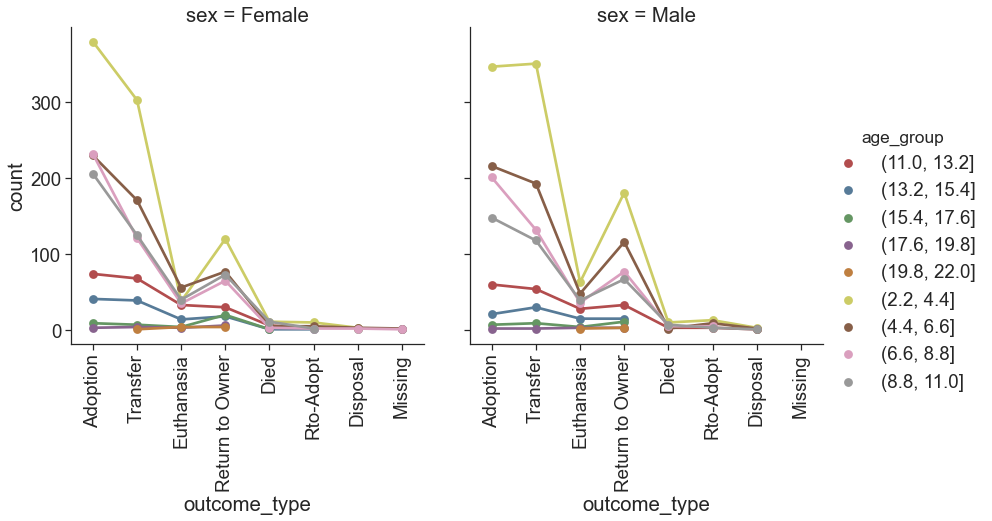

In [36]:
agegroup_counts2 = agegroup_counts[agegroup_counts['age_group'] != agegroup_counts['age_group'].unique()[0]]

g = sns.factorplot(x='outcome_type', y='count', hue='age_group', col='sex', 
                   data=agegroup_counts2, size=6)

g.set_xticklabels(rotation=90)

## Austin Animal Center Intakes Exploratory Data Analysis with Python, Pandas and Seaborn

In [37]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.error import HTTPError
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [38]:
def get_soda_api_data(endpoint, count=1000, offset=0, return_df=True):
    params = {'$limit': count, '$offset': offset}
    
    results = []

    while True:

        try:
            r = requests.get(endpoint, params=params)
            rcontent = r.json()

            if rcontent == []:
                break

            results.append(rcontent)
            offset += count
            params['$offset'] = offset

        except HTTPError as err:

            if err.response.status_code == '404':
                break
            else:
                print(err.response.status_code)
    
    if return_df:
        results_df = pd.DataFrame()

        for i in results:
            results_df = results_df.append(pd.io.json.json_normalize(i))
        
        return results_df
    
    else:
        return results

In [39]:
intakes_endpoint = 'https://data.austintexas.gov/resource/fdzn-9yqv.json'

intakes_df = get_soda_api_data(intakes_endpoint)

print(intakes_df.shape)
intakes_df.head()

(118068, 12)


,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake
0,1 year,A819026,Cat,Domestic Shorthair,Brown/White,2020-06-19T23:51:00.000,2020-06-19T23:51:00.000,6702 Bryn Mawr Dr in Austin (TX),Feral,Stray,NaN,Unknown
1,1 year,A779316,Dog,Labrador Retriever/Chinese Sharpei,Red,2020-06-19T17:13:00.000,2020-06-19T17:13:00.000,Austin (TX),Normal,Owner Surrender,Frankie,Spayed Female
2,1 month,A819025,Cat,Domestic Shorthair Mix,Blue Tabby,2020-06-19T16:53:00.000,2020-06-19T16:53:00.000,Lyndhurst Street in Austin (TX),Normal,Stray,NaN,Intact Female
3,0 years,A819024,Dog,Labrador Retriever Mix,Cream,2020-06-19T16:19:00.000,2020-06-19T16:19:00.000,Elroy Road And Fugerquist Road in Travis (TX),Normal,Stray,NaN,Intact Female
4,10 months,A819022,Cat,Domestic Shorthair,Brown Tabby,2020-06-19T15:27:00.000,2020-06-19T15:27:00.000,Austin (TX),Normal,Owner Surrender,Davie,Neutered Male


In [40]:
intakes_df.to_csv('data/aac_intakes.csv', 
                  encoding='utf-8', index=False)

In [41]:
intakes_df['count'] = 1

In [42]:
def transform_age(df, age_column):
    df = df.loc[df.loc[:, age_column] != 'NULL']
    
    range_column = age_column + '_Period Range'
    
    df[age_column + '_Periods'], df[range_column] = df.loc[:, age_column].str.split(' ').str[0].fillna(0).astype(int), df.loc[:, age_column].str.split(' ').str[1].fillna(0)
    
    
    df[range_column] = np.where(df[range_column].str.contains('day'), 1, 
                                  np.where(df[range_column].str.contains('week'), 7, 
                                           np.where(df[range_column].str.contains('month'), 30, 
                                                    np.where(df[range_column].str.contains('year'), 365, 0)))).astype(int)

    df[age_column + '_(days)'] = df[range_column] * df[age_column + '_Periods']
    df[age_column + '_(years)'] = df[age_column + '_(days)'] / 365
    
    df[age_column + '_age_group'] = pd.cut(df[age_column + '_(years)'], 10)

    return df


def transform_date(df, event):
    event_date = event + '_datetime'
    df[event_date] = pd.to_datetime(df['datetime'])

    df[event + '_month'] = df[event_date].dt.month
    df[event + '_year'] = df[event_date].dt.year
    df[event + '_monthyear'] = df[event + '_datetime'].dt.to_period('M')
    
    df[event + '_weekday'] = df[event_date].dt.weekday_name
    df[event + '_hour'] = df[event_date].dt.hour
    
    df.rename(columns={event + '_name': 'name'}, inplace=True)
    
    return df

In [43]:
intakes_df = transform_age(intakes_df, 'age_upon_intake')
intakes_df = transform_date(intakes_df, 'intake')

In [44]:
sns.set(style="white", context="talk", font_scale=2)

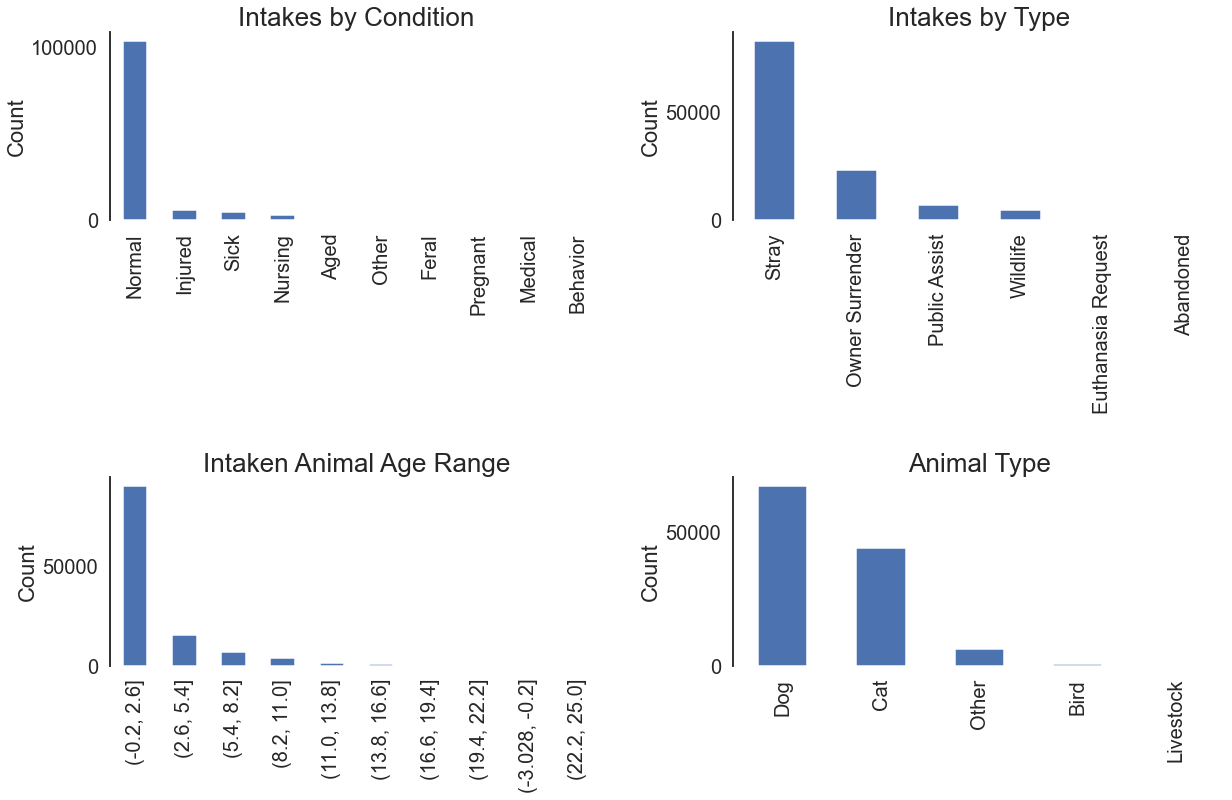

In [45]:
f, ax = plt.subplots(2, 2, figsize=(18, 12))

p1 = intakes_df['intake_condition'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Intakes by Condition', fontsize=26)

p2 = intakes_df['intake_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Intakes by Type', fontsize=26)

p3 = intakes_df['age_upon_intake_age_group'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,0])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Intaken Animal Age Range', fontsize=26)

p4 = intakes_df['animal_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,1])
p4.set_ylabel('Count', fontsize=22)
p4.set_title('Animal Type', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

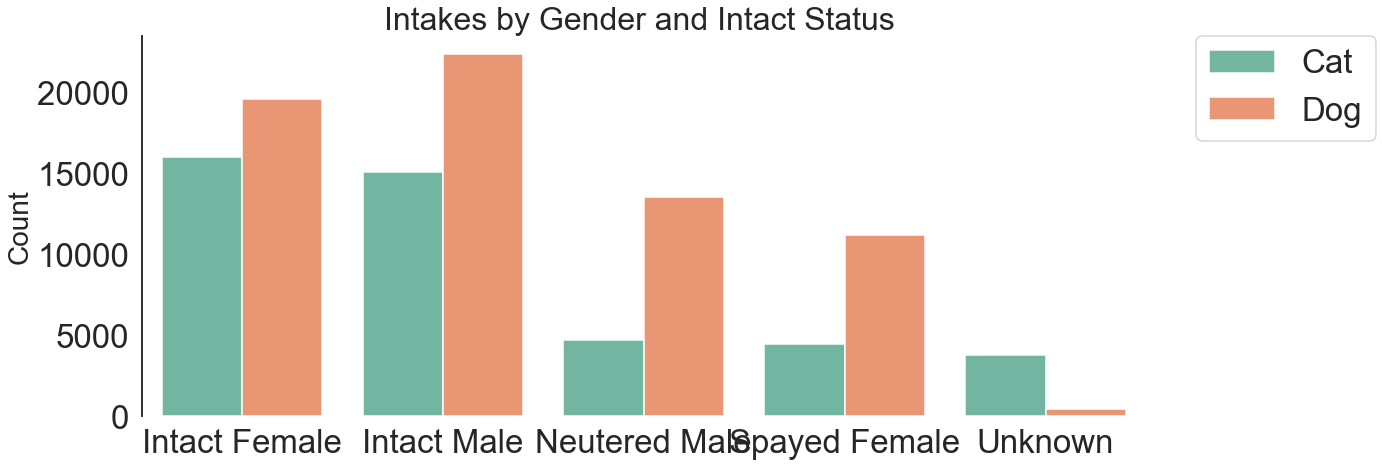

In [46]:
plt.figure(figsize=(18, 7))

intaken_animals = intakes_df.groupby(['animal_type', 'sex_upon_intake'])['count'].sum().reset_index()

intaken_animals = intaken_animals.loc[(intaken_animals['animal_type'] == 'Dog') | 
                                      (intaken_animals['animal_type'] == 'Cat')].loc[(intaken_animals['sex_upon_intake'] != 'NULL')]


bar = sns.barplot(x='sex_upon_intake', y='count', hue='animal_type', data=intaken_animals, 
                 palette=sns.color_palette("Set2", 10))

bar.set_title('Intakes by Gender and Intact Status ', fontsize=32)
bar.set_ylabel('Count', fontsize=28)
bar.axes.xaxis.label.set_visible(False)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

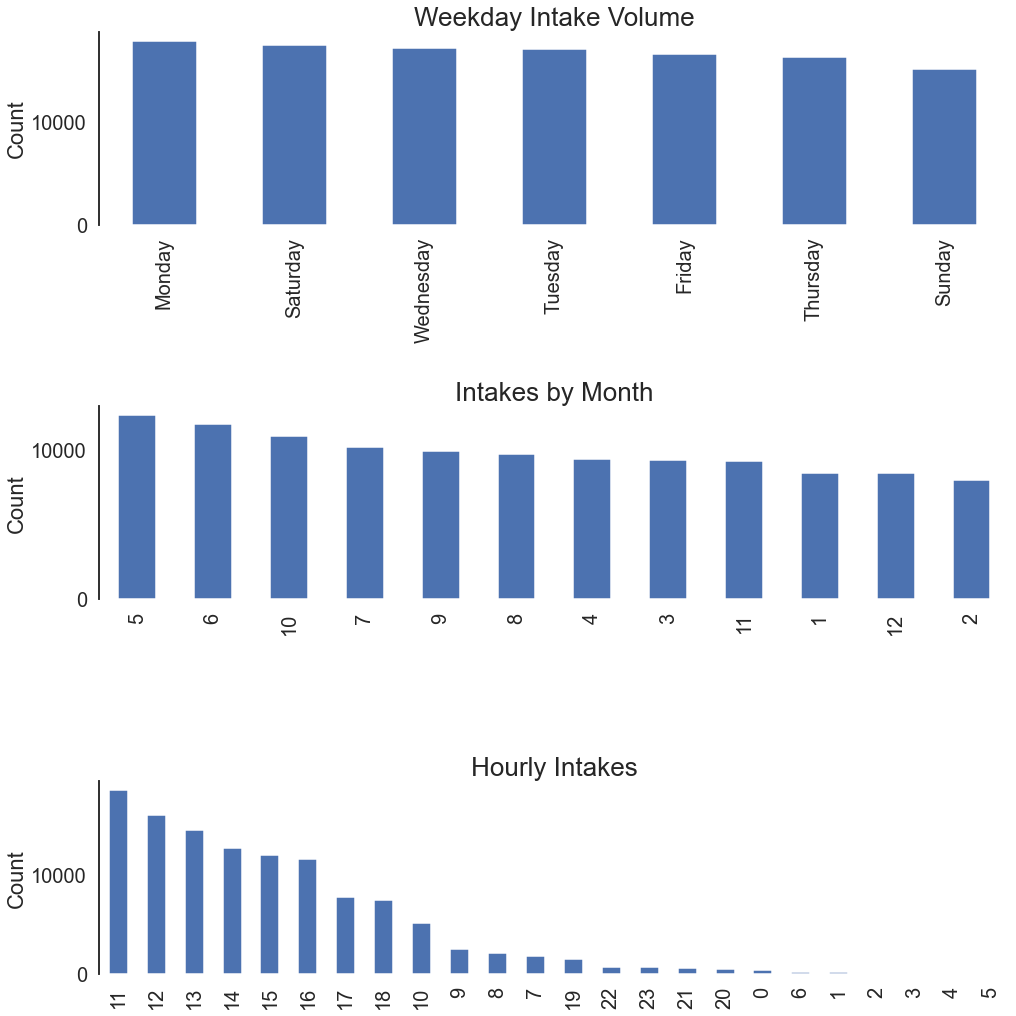

In [47]:
f, ax = plt.subplots(3, 1, figsize=(15, 15))

p1 = intakes_df['intake_weekday'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Weekday Intake Volume', fontsize=26)

p2 = intakes_df['intake_month'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Intakes by Month', fontsize=26)

p3 = intakes_df['intake_hour'].value_counts().plot(kind='bar', fontsize=20, ax=ax[2])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Hourly Intakes', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

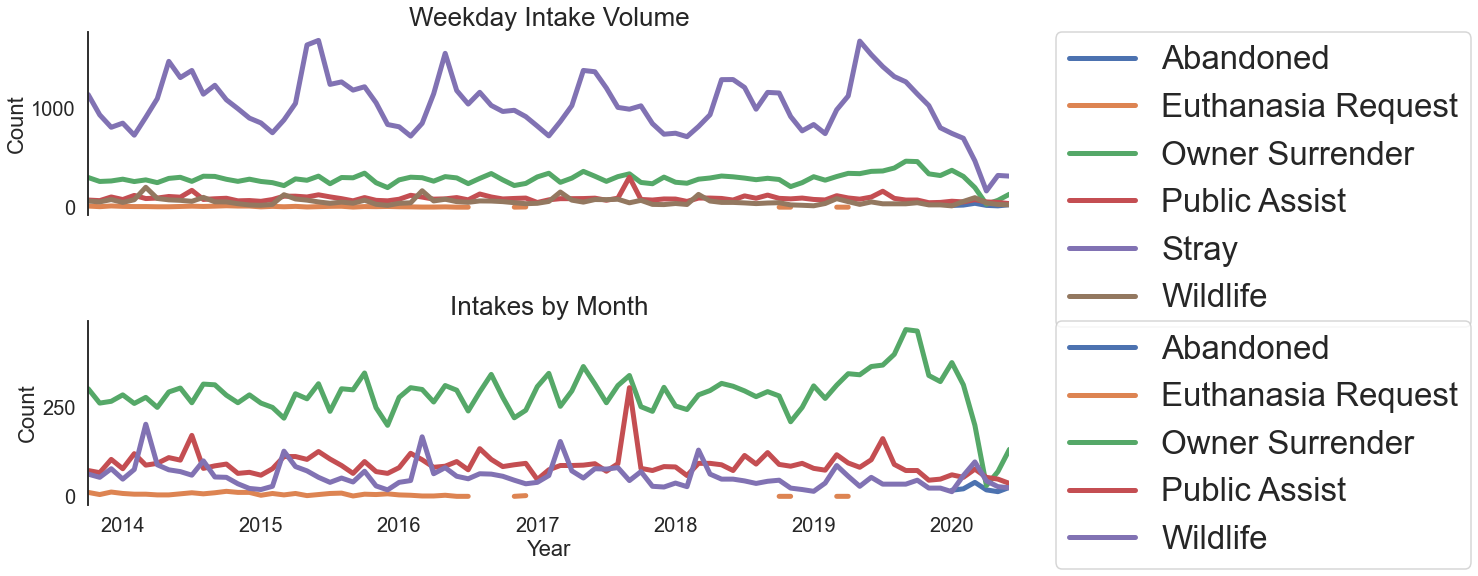

In [48]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

intakes_time = pd.pivot_table(intakes_df, 
                              index=['intake_monthyear'], columns=['intake_type'], 
                              values='count', aggfunc=np.sum)

intakes_nostray = intakes_time.copy()
del intakes_nostray['Stray']

p1 = intakes_time.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Weekday Intake Volume', fontsize=26)

p2 = intakes_nostray.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Year', fontsize=22)
p2.set_title('Intakes by Month', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

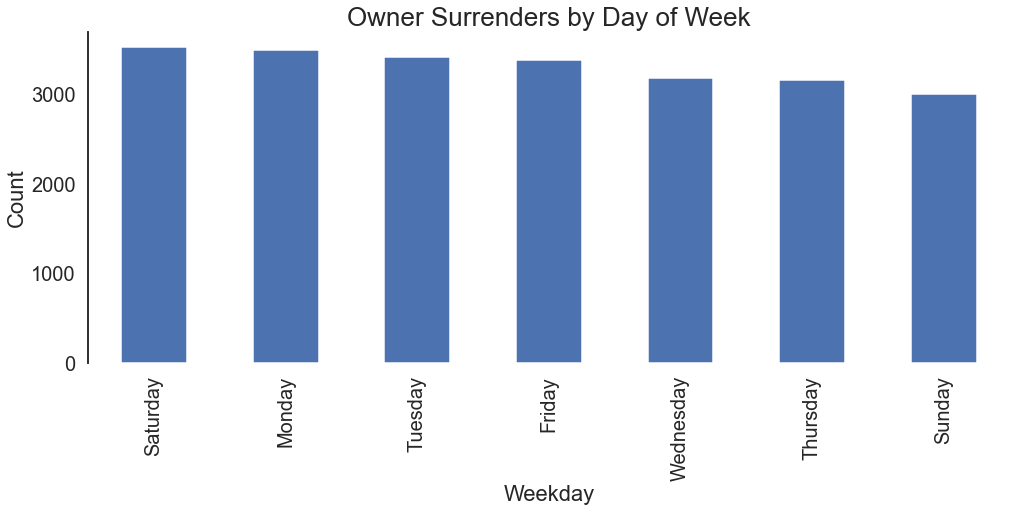

In [49]:
surrender_weekday = intakes_df.loc[intakes_df['intake_type'] == 'Owner Surrender']['intake_weekday'].value_counts().plot(kind='bar', 
                                                                                                                         fontsize=20, 
                                                                                                                         figsize=(15, 8))
surrender_weekday.set_ylabel('Count', fontsize=22)
surrender_weekday.set_xlabel('Weekday', fontsize=22)
surrender_weekday.set_title('Owner Surrenders by Day of Week', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

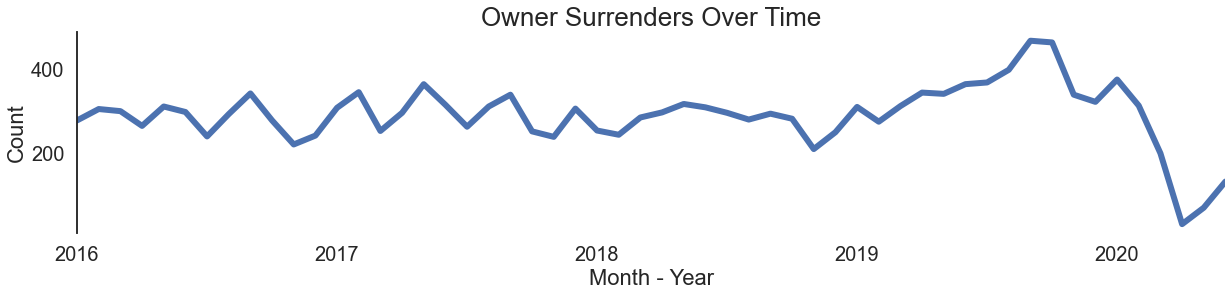

In [50]:
surr_over_time = intakes_time.loc[intakes_time.index >= '2016-01-01']['Owner Surrender'].plot(kind='line', 
                                                                                              linewidth=6,
                                                                                              fontsize=20,
                                                                                              figsize=(18, 5))

surr_over_time.set_ylabel('Count', fontsize=22)
surr_over_time.set_xlabel('Month - Year', fontsize=22)
surr_over_time.set_title('Owner Surrenders Over Time', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

In [51]:
intakes_df['month_start_end'] = np.where(intakes_df['intake_datetime'].dt.is_month_start, 'Start', 
                                        np.where(intakes_df['intake_datetime'].dt.is_month_end, 'End', 'Middle'))

intakes_df.groupby(['intake_datetime', 'month_start_end'])['count'].sum().groupby('month_start_end').mean()

month_start_end
End       1.414340
Middle    1.415946
Start     1.431694
Name: count, dtype: float64

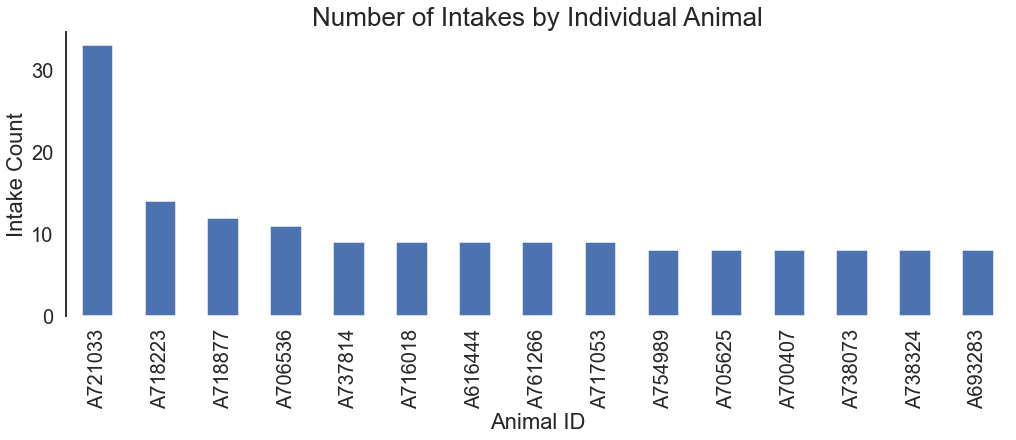

In [52]:
animal_intakes = intakes_df['animal_id'].value_counts()[0:15].plot(kind='bar', 
                                                                   fontsize=20,
                                                                   figsize=(15, 7))

animal_intakes.set_ylabel('Intake Count', fontsize=22)
animal_intakes.set_xlabel('Animal ID', fontsize=22)
animal_intakes.set_title('Number of Intakes by Individual Animal', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

In [53]:
count = np.arange(2, 9)

intake_count = []
intake_name = []

for i in count:
    if i != 8:
        intakes = intakes_df['animal_id'].value_counts() == i
        intake_name.append(str(i) + ' Intakes')
    else:
        intakes = intakes_df['animal_id'].value_counts() >= i
        intake_name.append(str(i) + ' or Greater Intakes')
    
    intake_count.append(intakes.sum())

In [54]:
pd.DataFrame({'count': intake_count}, index=intake_name)

,count
2 Intakes,7661
3 Intakes,1403
4 Intakes,375
5 Intakes,103
6 Intakes,45
7 Intakes,28
8 or Greater Intakes,19


In [55]:
mult_intakes = intakes_df.loc[intakes_df['animal_id'].isin(intakes_df['animal_id'].value_counts()[intakes_df['animal_id'].value_counts() >= 2].index)].reset_index()

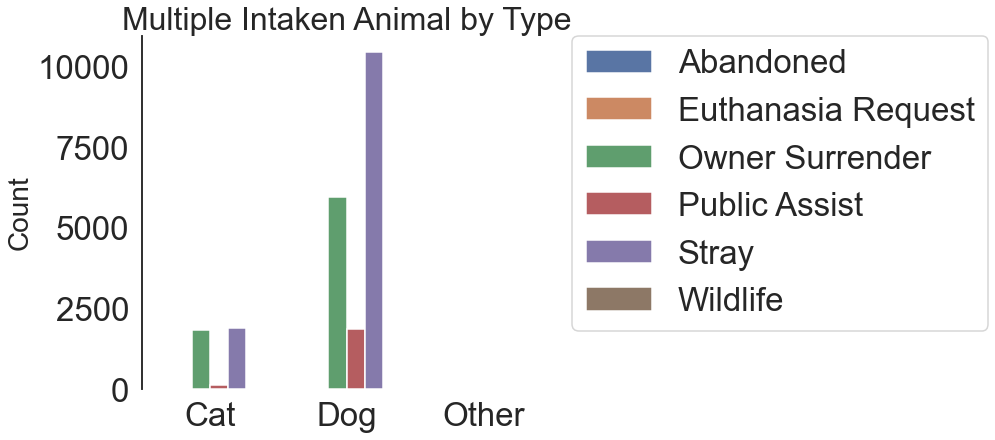

In [56]:
mult_intakes_types = pd.pivot_table(mult_intakes, 
                                   index=['animal_type', 'intake_type'],
                                    values=['count'], aggfunc=np.sum).reset_index()

plt.figure(figsize=(15, 7))

bar = sns.barplot(x='animal_type', y='count', hue='intake_type', data=mult_intakes_types)

bar.set_title('Multiple Intaken Animal by Type', fontsize=32)
bar.set_ylabel('Count', fontsize=28)

bar.axes.xaxis.label.set_visible(False)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
sns.despine(bottom=True)

In [57]:
intakes_df.reset_index(inplace=True)

intakes_df['intake_number'] = intakes_df.groupby(['animal_id'])['intake_datetime'].rank(method='dense', ascending=False)
intakes_df['animal_id_new'] = intakes_df['animal_id'] + '_' + intakes_df['intake_number'].astype(int).astype(str)

In [58]:
del intakes_df['datetime']
del intakes_df['datetime2']
del intakes_df['age_upon_intake_Periods']
del intakes_df['age_upon_intake_Period Range']
del intakes_df['month_start_end']

intakes_df.to_csv('data/aac_intakes_transformed.csv')

In [59]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.error import HTTPError
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [60]:
import aac_analysis as aac

In [61]:
outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

outcomes_df = aac.get_soda_api_data(outcomes_endpoint)

In [62]:
outcomes_df.to_csv('data/aac_outcomes.csv', 
                   encoding='utf-8', index=False)

In [63]:
def transform_birthdates(df):
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])

    df['dob_year'] = df['date_of_birth'].dt.year
    df['dob_month'] = df['date_of_birth'].dt.month
    df['dob_monthyear'] = pd.to_datetime(df['monthyear']).dt.to_period('M')

    return df

In [64]:
outcomes_df = aac.transform_age(outcomes_df, 'age_upon_outcome')
outcomes_df = aac.transform_date(outcomes_df, 'outcome')
outcomes_df = aac.create_unique_id(outcomes_df, 'outcome')
outcomes_df = transform_birthdates(outcomes_df)

outcomes_df.head()

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,...,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,animal_id_new,dob_year,dob_month,dob_monthyear
0,0,1 year,A818840,Other,Raccoon,Black,2019-06-16,2020-06-20T08:48:00.000,2020-06-20T08:48:00.000,NaN,...,6,2020,2020-06,Saturday,8,1.0,A818840_1,2019,6,2020-06
1,1,1 year,A818896,Other,Bat,Red,2019-06-17,2020-06-20T08:47:00.000,2020-06-20T08:47:00.000,NaN,...,6,2020,2020-06,Saturday,8,1.0,A818896_1,2019,6,2020-06
2,2,2 years,A814669,Dog,Greyhound/Labrador Retriever,Tan/Black,2018-03-03,2020-06-19T17:48:00.000,2020-06-19T17:48:00.000,*Finn,...,6,2020,2020-06,Friday,17,1.0,A814669_1,2018,3,2020-06
3,3,4 months,A818492,Cat,Domestic Medium Hair,Black,2020-02-09,2020-06-19T17:13:00.000,2020-06-19T17:13:00.000,*Virgo,...,6,2020,2020-06,Friday,17,1.0,A818492_1,2020,2,2020-06
4,4,4 months,A818489,Cat,Domestic Medium Hair,Black,2020-02-09,2020-06-19T17:13:00.000,2020-06-19T17:13:00.000,*Capricorn,...,6,2020,2020-06,Friday,17,1.0,A818489_1,2020,2,2020-06


In [65]:
intakes_df = pd.read_csv('data/aac_intakes_transformed.csv')

In [66]:
set(intakes_df.columns).intersection(outcomes_df.columns)

{'animal_id',
 'animal_id_new',
 'animal_type',
 'breed',
 'color',
 'index',
 'name'}

In [67]:
cols_to_drop = ['index', 'name']

outcomes_df.drop(['animal_type', 'breed', 'color'] + cols_to_drop, axis=1, inplace=True)
intakes_df.drop(cols_to_drop, axis=1, inplace=True)

In [68]:
outcomes_df.set_index('animal_id_new', inplace=True)
intakes_df.set_index('animal_id_new', inplace=True)

in_out = pd.merge(outcomes_df, intakes_df, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_intake'])

In [69]:
print(in_out.columns)
print(in_out.shape)
in_out.head()

Index(['age_upon_outcome', 'animal_id_outcome', 'date_of_birth', 'datetime',
       'monthyear', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome',
       'age_upon_outcome_Periods', 'age_upon_outcome_Period Range',
       'age_upon_outcome_(days)', 'age_upon_outcome_(years)',
       'age_upon_outcome_age_group', 'outcome_datetime', 'outcome_month',
       'outcome_year', 'outcome_monthyear', 'outcome_weekday', 'outcome_hour',
       'outcome_number', 'dob_year', 'dob_month', 'dob_monthyear',
       'Unnamed: 0', 'age_upon_intake', 'animal_id_intake', 'animal_type',
       'breed', 'color', 'found_location', 'intake_condition', 'intake_type',
       'sex_upon_intake', 'count', 'age_upon_intake_(days)',
       'age_upon_intake_(years)', 'age_upon_intake_age_group',
       'intake_datetime', 'intake_month', 'intake_year', 'intake_monthyear',
       'intake_weekday', 'intake_hour', 'intake_number'],
      dtype='object')
(117334, 44)


,age_upon_outcome,animal_id_outcome,date_of_birth,datetime,monthyear,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_Periods,age_upon_outcome_Period Range,...,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number
animal_id_new,,,,,,,,,,,,,,,,,,,,,
A006100_1,10 years,A006100,2007-07-09,2017-12-07T00:00:00.000,2017-12-07T00:00:00.000,NaN,Return to Owner,Neutered Male,10,365,...,3650,10.0,"(8.2, 11.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,14,1.0
A006100_2,7 years,A006100,2007-07-09,2014-12-20T16:35:00.000,2014-12-20T16:35:00.000,NaN,Return to Owner,Neutered Male,7,365,...,2555,7.0,"(5.4, 8.2]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0
A006100_3,6 years,A006100,2007-07-09,2014-03-08T17:10:00.000,2014-03-08T17:10:00.000,NaN,Return to Owner,Neutered Male,6,365,...,2190,6.0,"(5.4, 8.2]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0
A047759_1,10 years,A047759,2004-04-02,2014-04-07T15:12:00.000,2014-04-07T15:12:00.000,Partner,Transfer,Neutered Male,10,365,...,3650,10.0,"(8.2, 11.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0
A134067_1,16 years,A134067,1997-10-16,2013-11-16T11:54:00.000,2013-11-16T11:54:00.000,NaN,Return to Owner,Neutered Male,16,365,...,5840,16.0,"(13.8, 16.6]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0


In [70]:
in_out['outcome_datetime'] = pd.to_datetime(in_out['outcome_datetime'])
in_out['intake_datetime'] = pd.to_datetime(in_out['intake_datetime'])

in_out['time_in_shelter'] = in_out['outcome_datetime'] - in_out['intake_datetime']

In [71]:
in_out['time_in_shelter'].describe()

count                     117334
mean     17 days 03:37:24.704348
std      46 days 12:25:14.653007
min         -2199 days +00:45:00
25%              1 days 05:44:00
50%              5 days 01:31:00
75%             14 days 18:03:45
max           1521 days 23:31:00
Name: time_in_shelter, dtype: object

In [72]:
in_later = in_out[['intake_datetime', 'outcome_datetime']][in_out['intake_datetime'] > in_out['outcome_datetime']]

print(len(in_later))
in_later.head()

707


,intake_datetime,outcome_datetime
animal_id_new,,
A006100_1,2017-12-07 14:07:00,2017-12-07
A531969_1,2015-11-13 12:18:00,2015-11-13
A533243_2,2016-12-20 16:50:00,2016-12-20
A554047_2,2016-05-26 16:33:00,2016-05-26
A554047_3,2016-05-14 11:26:00,2016-05-14


In [73]:
in_out['intake_datetime'], in_out['outcome_datetime'] = np.where(in_out['intake_datetime'] > in_out['outcome_datetime'],
                                                                [in_out['outcome_datetime'], in_out['intake_datetime']],
                                                                [in_out['intake_datetime'], in_out['outcome_datetime']])

In [74]:
in_out['time_in_shelter'] = pd.to_datetime(in_out['outcome_datetime']) - pd.to_datetime(in_out['intake_datetime'])
in_out['time_in_shelter'].describe()

count                     117334
mean     18 days 02:14:16.483713
std      46 days 03:49:14.131312
min              0 days 00:00:00
25%              1 days 06:06:00
50%              5 days 01:43:00
75%             14 days 21:00:45
max           2198 days 23:15:00
Name: time_in_shelter, dtype: object

In [75]:
in_out[['intake_datetime', 'outcome_datetime']][in_out['intake_datetime'] > in_out['outcome_datetime']]

,intake_datetime,outcome_datetime
animal_id_new,,


In [76]:
del in_out['Unnamed: 0']
del in_out['monthyear']
del in_out['age_upon_outcome_Periods']
del in_out['age_upon_outcome_Period Range']
del in_out['datetime']

in_out.to_csv('data/aac_intakes_outcomes.csv', 
              encoding='utf-8', index=False)

In [77]:
sns.set(style="white", context="talk", font_scale=1.2)

In [78]:
in_out['animal_type'].value_counts()

Dog          66832
Cat          43797
Other         6140
Bird           549
Livestock       16
Name: animal_type, dtype: int64

In [79]:
in_out = in_out.loc[in_out['animal_type'] != 'Livestock']

In [80]:
in_out['time_in_shelter'] = pd.to_timedelta(in_out['time_in_shelter'])
in_out['time_in_shelter_days'] = in_out['time_in_shelter'].dt.total_seconds() / (24 * 60 * 60)

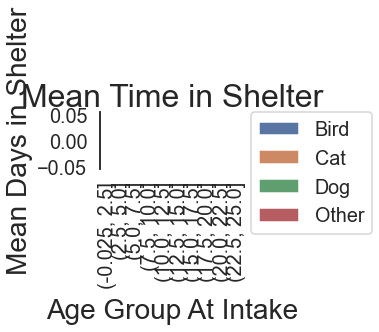

In [81]:
animal_shelter_time = in_out.groupby(['animal_type', 
                                      'age_upon_intake_age_group'])['time_in_shelter_days'].mean().reset_index()

bar = sns.barplot(x='age_upon_intake_age_group', y='time_in_shelter_days', 
                  hue='animal_type', data=animal_shelter_time, order=['(-0.025, 2.5]', '(2.5, 5.0]', '(5.0, 7.5]', 
                                                                     '(7.5, 10.0]', '(10.0, 12.5]', '(12.5, 15.0]', 
                                                                     '(15.0, 17.5]', '(17.5, 20.0]', '(20.0, 22.5]', 
                                                                      '(22.5, 25.0]'])

bar.set_title('Mean Time in Shelter', fontsize=32)
bar.set_ylabel('Mean Days in Shelter', fontsize=28)
bar.set_xlabel('Age Group At Intake', fontsize=28)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
sns.despine(bottom=True)

In [82]:
print('Overall:')
print(in_out['age_upon_intake_age_group'].value_counts())
print('Cats:')
print(in_out.loc[in_out['animal_type'] == 'Cat']['age_upon_intake_age_group'].value_counts())

Overall:
(-0.2, 2.6]       89071
(2.6, 5.4]        15221
(5.4, 8.2]         6971
(8.2, 11.0]        3684
(11.0, 13.8]       1379
(13.8, 16.6]        816
(16.6, 19.4]        147
(19.4, 22.2]         22
(-3.028, -0.2]        5
(22.2, 25.0]          2
Name: age_upon_intake_age_group, dtype: int64
Cats:
(-0.2, 2.6]     37511
(2.6, 5.4]       3008
(5.4, 8.2]       1546
(8.2, 11.0]       941
(11.0, 13.8]      440
(13.8, 16.6]      271
(16.6, 19.4]       63
(19.4, 22.2]       17
Name: age_upon_intake_age_group, dtype: int64


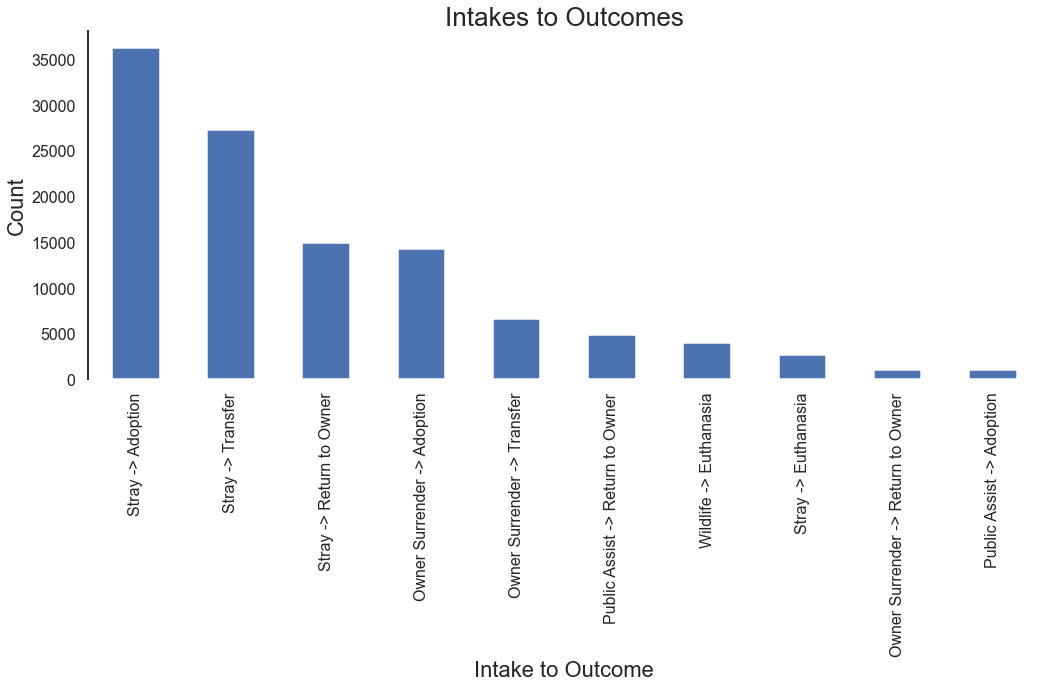

In [83]:
in_out['Intake_Outcome'] = in_out['intake_type'] + ' -> ' + in_out['outcome_type']

intake_outcomes = in_out['Intake_Outcome'].value_counts()[0:10].plot(kind='bar', 
                                                                     fontsize=16, 
                                                                     figsize=(15, 10))
intake_outcomes.set_ylabel('Count', fontsize=22)
intake_outcomes.set_xlabel('Intake to Outcome', fontsize=22)
intake_outcomes.set_title('Intakes to Outcomes', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

In [84]:
for i in range(1, 10):
    print(in_out['Intake_Outcome'].value_counts()[0:i].sum() / in_out['Intake_Outcome'].value_counts().sum())

0.3087296378065517
0.5407670079189859
0.6675389769249784
0.7887361162019555
0.8451833982593574
0.8860313861208903
0.9200173893771364
0.9423849019290275
0.9512415503823106


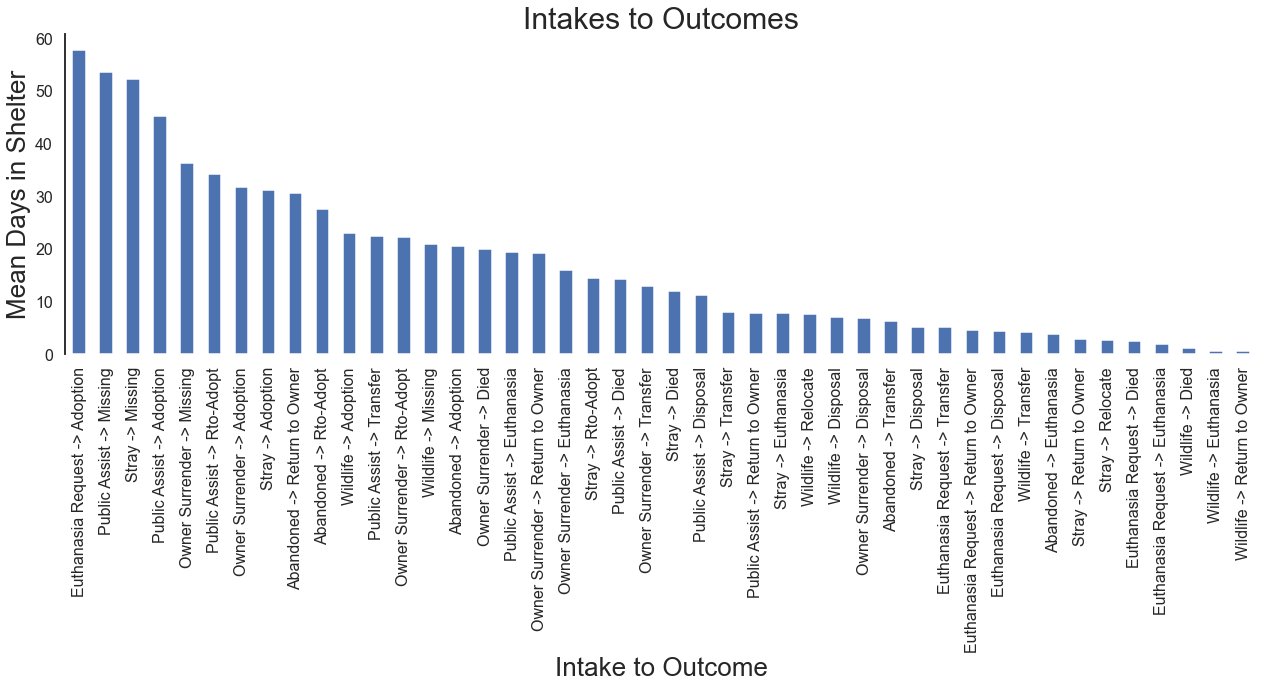

In [85]:
intake_outcome_days = in_out.groupby('Intake_Outcome')['time_in_shelter_days'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                                                        fontsize=16, 
                                                                                                                        figsize=(18, 10))

intake_outcome_days.set_ylabel('Mean Days in Shelter', fontsize=26)
intake_outcome_days.set_xlabel('Intake to Outcome', fontsize=26)
intake_outcome_days.set_title('Intakes to Outcomes', fontsize=30)

plt.tight_layout()
sns.despine(bottom=True)

<Figure size 432x288 with 0 Axes>

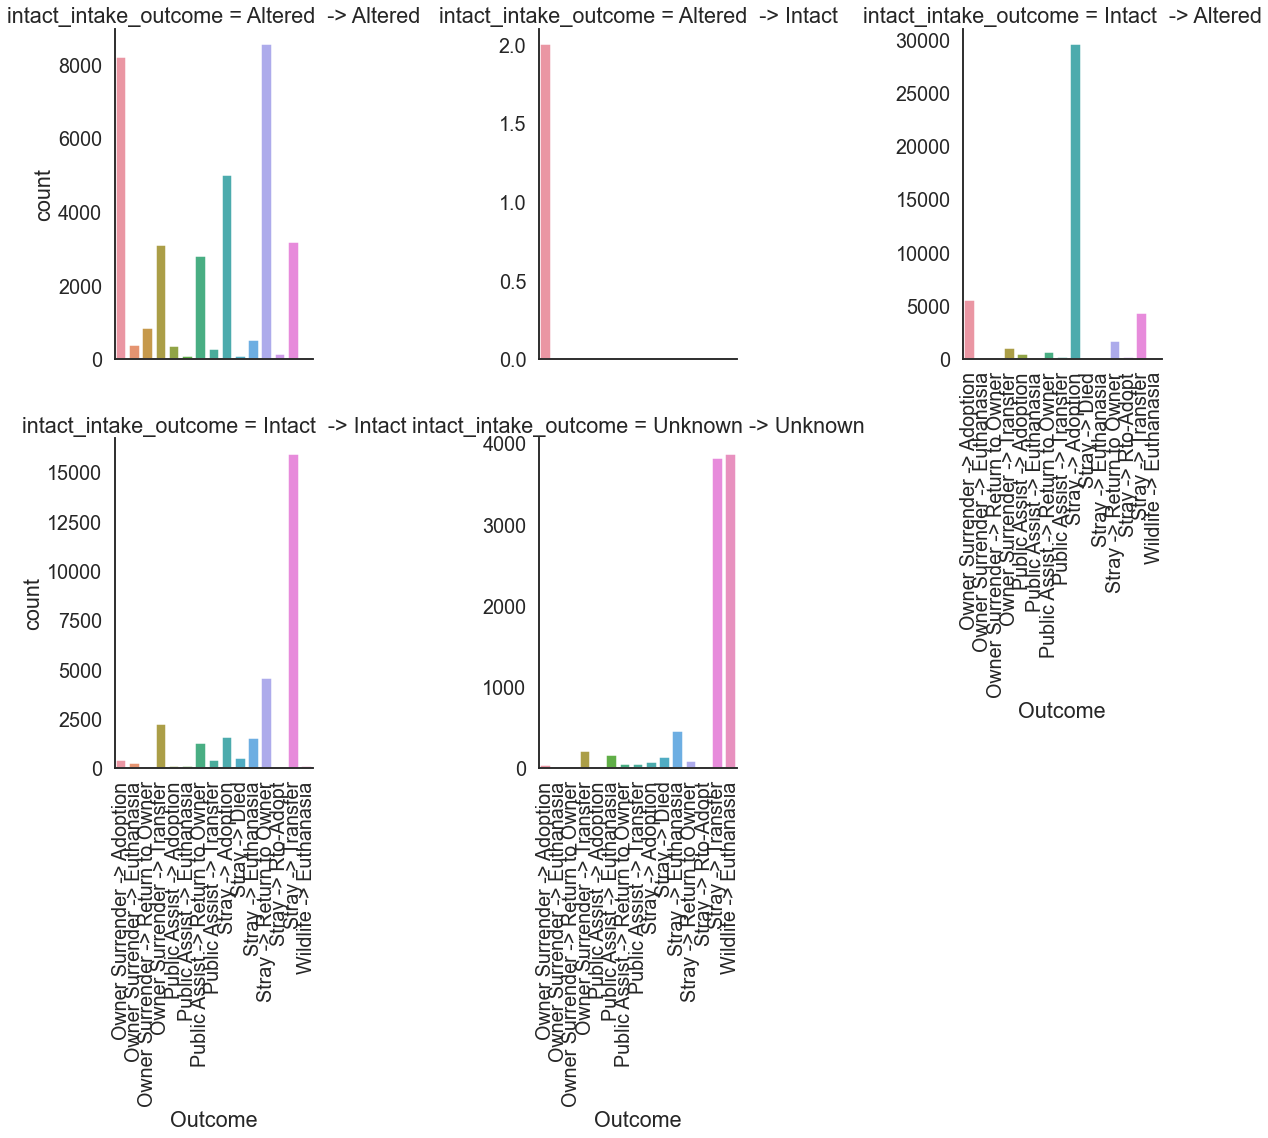

In [86]:
in_out['intact_intake_outcome'] = in_out['sex_upon_intake'] + ' -> ' + in_out['sex_upon_outcome']

in_out['intact_intake_outcome'] = in_out['intact_intake_outcome'].str.replace('Neutered|Spayed', 'Altered').str.strip()
in_out['intact_intake_outcome'] = in_out['intact_intake_outcome'].str.replace('Male|Female', '').str.strip()

top_outcomes = in_out.loc[in_out['Intake_Outcome'].isin(in_out['Intake_Outcome'].value_counts()[0:15].index)]

top_outcomes_sex = top_outcomes.groupby(['intact_intake_outcome', 
                                        'Intake_Outcome'])['count'].sum().reset_index()

plt.tight_layout()
sns.despine(bottom=True)

fact = sns.factorplot(x='Intake_Outcome', y='count', col='intact_intake_outcome', 
               kind='bar', sharey=False, col_wrap=3, size=6, data=top_outcomes_sex, ci=None)

fact.set_xticklabels(rotation=90)
fact.set_xlabels('Outcome')

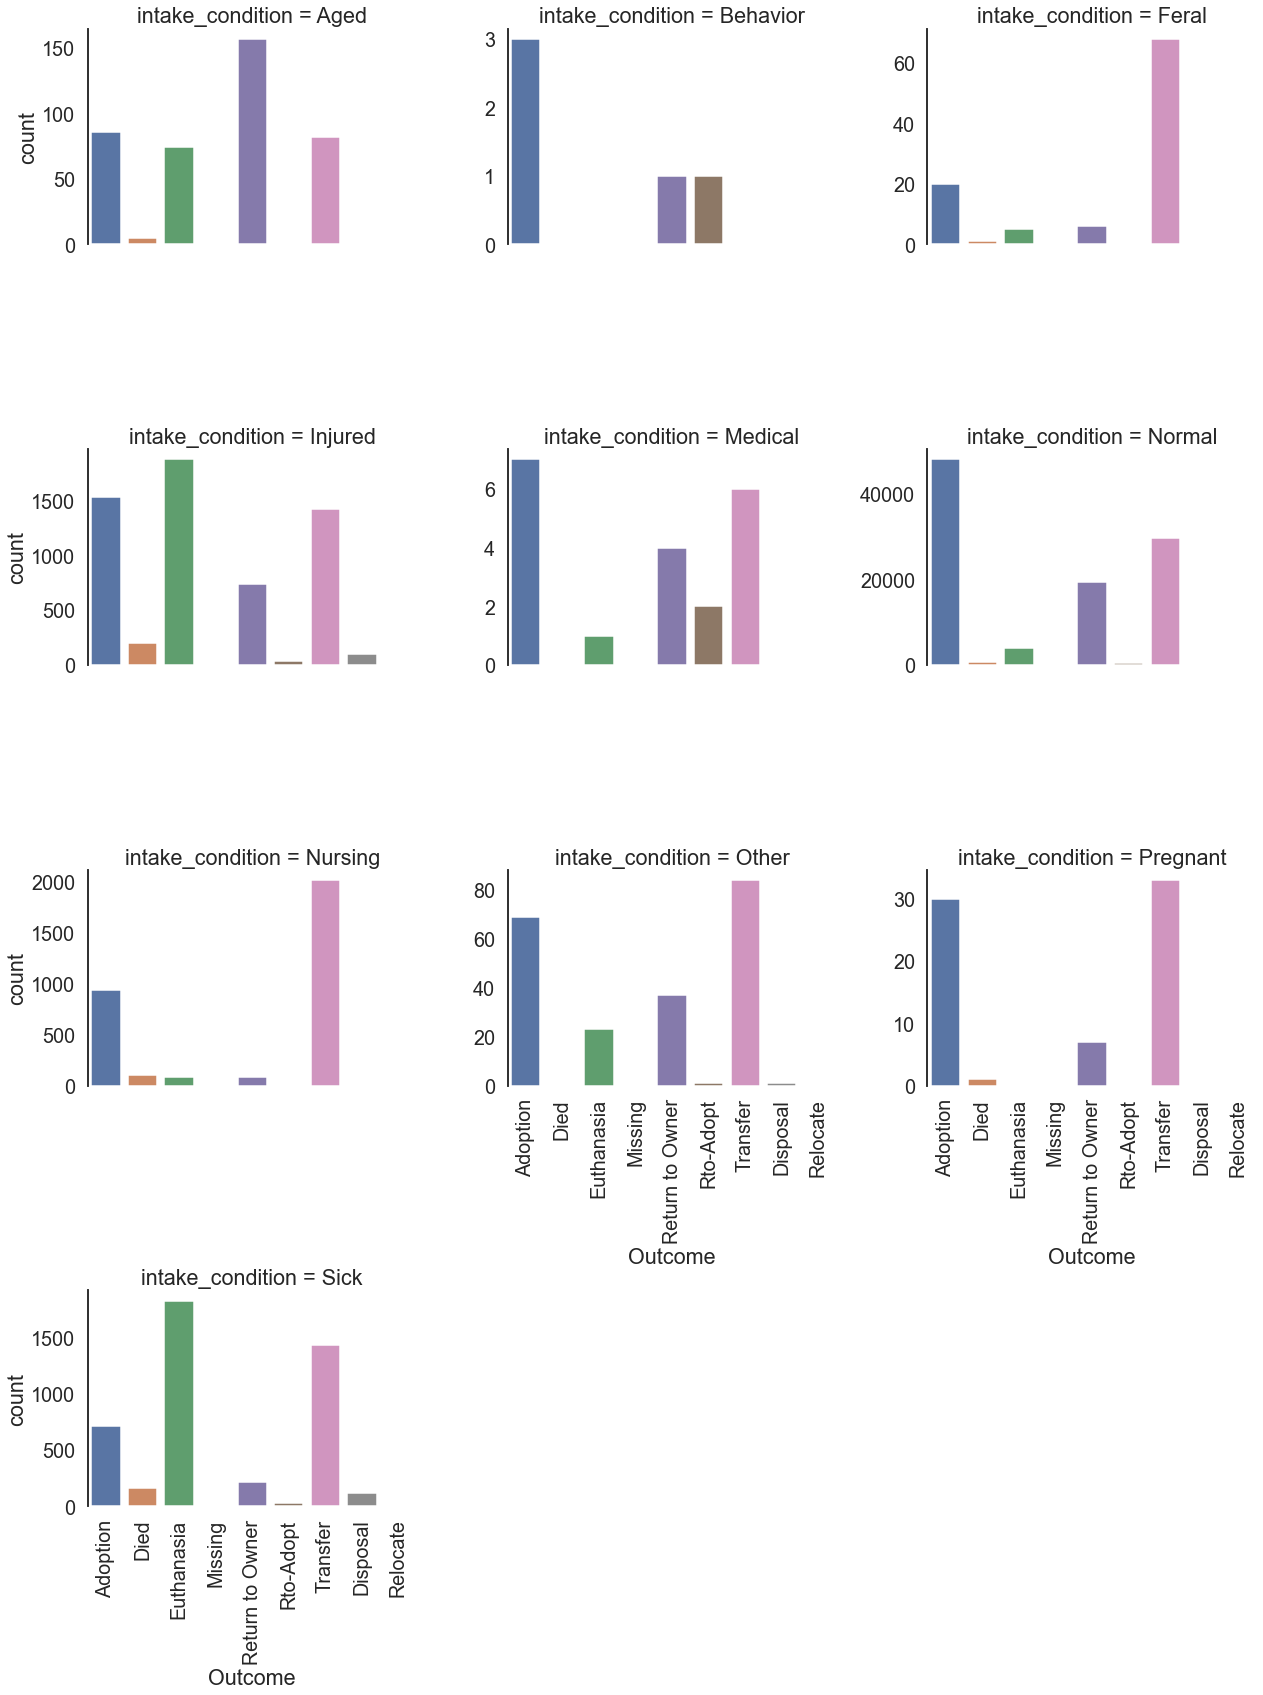

In [87]:
in_out['intake_cond_outcome'] = in_out['intake_condition'] + ' -> ' + in_out['outcome_type']
intake_cond_out = in_out.groupby(['intake_condition', 'outcome_type'])['count'].sum().reset_index()

g = sns.factorplot(x='outcome_type', y='count', col='intake_condition', 
                   col_wrap=3, kind='bar', size=6, sharey=False, data=intake_cond_out)

g.set_xticklabels(rotation=90)
g.set_xlabels('Outcome')

plt.tight_layout()
sns.despine(bottom=True)

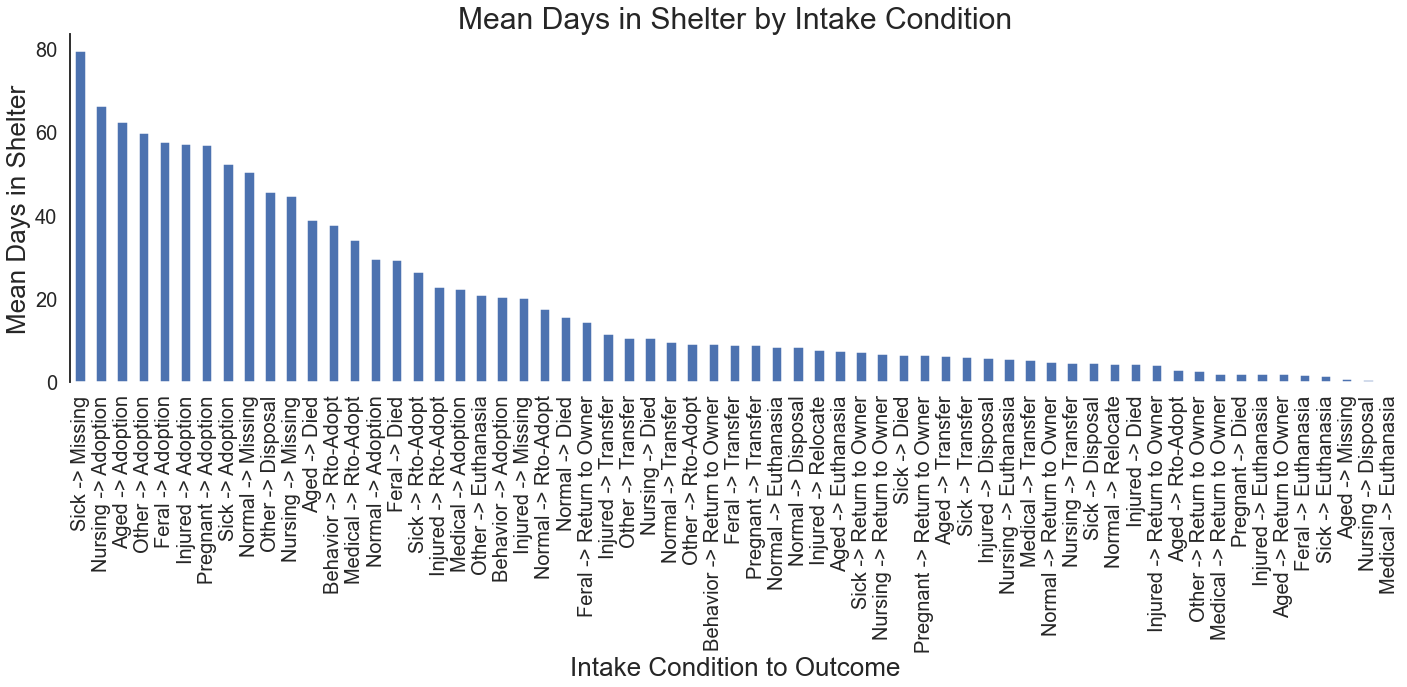

In [88]:
intake_cond_out_time = in_out.groupby(['intake_cond_outcome'])['time_in_shelter_days'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                                                                figsize=(20, 10),
                                                                                                                                fontsize=20)
intake_cond_out_time.set_ylabel('Mean Days in Shelter', fontsize=26)
intake_cond_out_time.set_xlabel('Intake Condition to Outcome', fontsize=26)
intake_cond_out_time.set_title('Mean Days in Shelter by Intake Condition', fontsize=30)

plt.tight_layout()
sns.despine(bottom=True)

In [89]:
in_out = in_out.loc[:,:'time_in_shelter_days']
in_out.to_csv('data/aac_intakes_outcomes.csv', 
              encoding='utf-8', index=False)

## Predicting Shelter Cat Adoptions and Transfers with Scikit-learn and Machine Learning

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.externals import joblib

import warnings
warnings.simplefilter('ignore')

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [92]:
cat_outcomes = pd.read_csv('data/cats_df_clean.csv')

In [93]:
cat_outcomes = cat_outcomes.loc[(cat_outcomes['outcome_type'] == 'Adoption') | 
                                 (cat_outcomes['outcome_type'] == 'Transfer')]

In [94]:
cat_outcomes['outcome_subtype'] = np.where(pd.isnull(cat_outcomes['outcome_subtype']), 
                                           cat_outcomes['outcome_type'], 
                                           cat_outcomes['outcome_subtype'])

In [95]:
cat_outcomes['outcome_subtype'].value_counts()

Adoption    12621
Partner     11332
Foster       4602
Snr          2562
SCRP         2242
Offsite        48
Barn            3
Name: outcome_subtype, dtype: int64

In [96]:
x = cat_outcomes.filter(items=['sex_upon_outcome', 'breed', 'color', 'coat_pattern', 
                               'domestic_breed', 'dob_month', 'age_group', 'outcome_month', 
                               'outcome_weekday', 'outcome_hour', 'Cat/Kitten (outcome)'])

In [97]:
for col in x:
    x[col] = x[col].astype('category')
    
y = cat_outcomes['outcome_subtype'].astype('category')

In [98]:
xd = pd.get_dummies(x)

In [99]:
xnames = xd.columns
xarr = np.array(xd)

In [100]:
yarr, ynames = pd.factorize(cat_outcomes['outcome_subtype'])

In [101]:
x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)

In [102]:
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [103]:
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

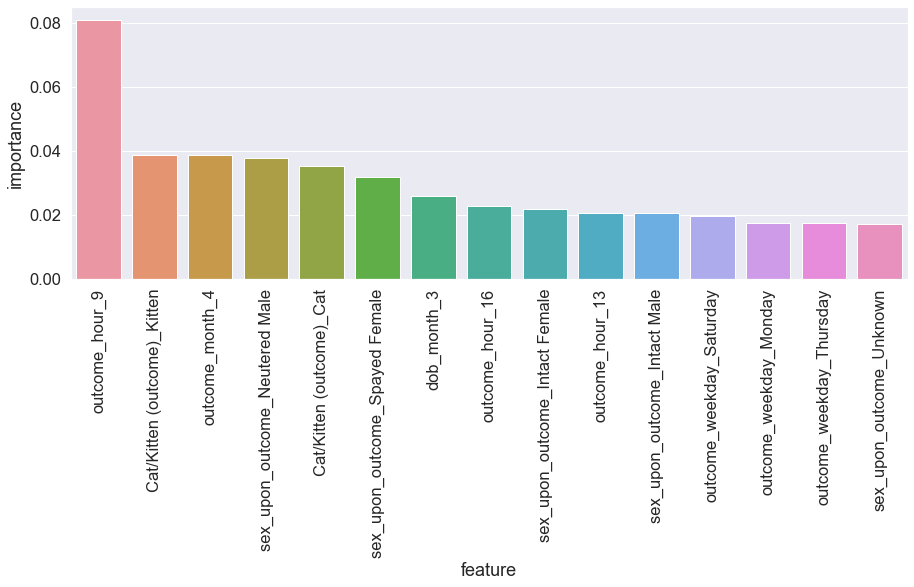

In [104]:
feature_importances = rf_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

In [105]:
pca = PCA()
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [106]:
print(len(pca.components_))

300


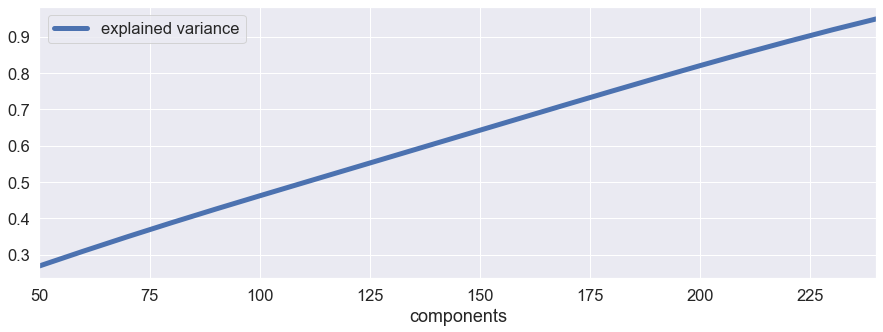

In [107]:
comps = np.arange(50, 250, 10)
exp_var = []

for comp in comps:
    exp_var.append(sum(pca.explained_variance_ratio_[0:comp]))
    
pca_exp_var = pd.concat([pd.Series(comps, name='components'), 
                         pd.Series(exp_var, name='explained variance')], axis=1)

pca_exp_var.set_index('components', inplace=True)

pca_exp_var.plot(kind='line', linewidth=5, figsize=(15, 5))

In [108]:
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

In [109]:
prediction_model.fit(x_train_scaled, y_train)

Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pca',
                                                 PCA(copy=True,
                                                     iterated_power='auto',
                                                     n_components=None,
                                                     random_state=None,
                                                     svd_solver='auto', tol=0.0,
                                                     whiten=False)),
                                                ('kbest',
                                                 SelectKBest(k=10,
                                                             score_func=<function f_classif at 0x000002488D56B9D8>))],
                              transformer_weights=None, verbose=False)),
                ('rf',
                 RandomForestCla...0,
                                 

In [110]:
cv = StratifiedKFold(2)

In [111]:
cv_score = cross_val_score(prediction_model, x_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train_scaled, y_train, cv=cv)

In [112]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))

[0.73319651 0.72975284]
0.7314746773064641
0.7320733740967204


In [113]:
rf_pred = prediction_model.predict(x_test_scaled)

In [114]:
print(accuracy_score(y_test, rf_pred))

0.7458844657288237


Normalized confusion matrix
Confusion matrix, without normalization


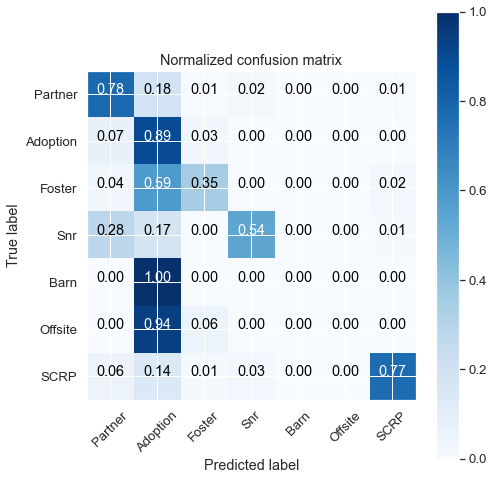

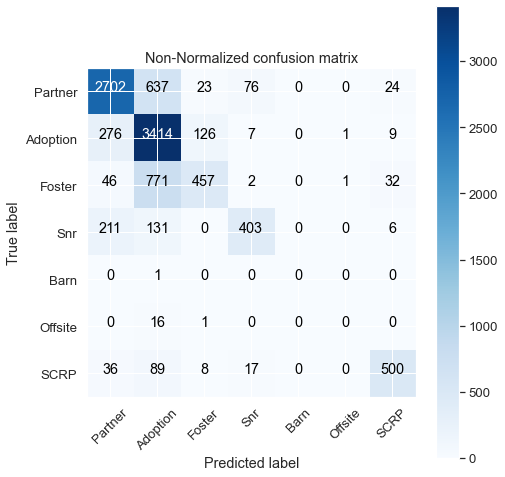

In [115]:
sns.set(font_scale=1.2)

rf_cnf_mat = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=False, title='Non-Normalized confusion matrix')

plt.show()

In [116]:
print(classification_report(y_test, rf_pred, target_names=ynames))

              precision    recall  f1-score   support

     Partner       0.83      0.78      0.80      3462
    Adoption       0.67      0.89      0.77      3833
      Foster       0.74      0.35      0.48      1309
         Snr       0.80      0.54      0.64       751
        Barn       0.00      0.00      0.00         1
     Offsite       0.00      0.00      0.00        17
        SCRP       0.88      0.77      0.82       650

    accuracy                           0.75     10023
   macro avg       0.56      0.48      0.50     10023
weighted avg       0.76      0.75      0.73     10023



In [117]:
criterion = ['gini', 'entropy']
components = [175, 200, 225]
estimators = [100, 250, 500]
k = [10, 15, 20]

In [118]:
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model_tune = Pipeline([
    ('feature_union', feature_union),
    ('rf', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced_subsample', 
                                                      bootstrap=True, oob_score=True)))
])

rf_gridcv = GridSearchCV(prediction_model_tune, dict(feature_union__pca__n_components=components, 
                                                     feature_union__kbest__k=k, 
                                                     rf__estimator__n_estimators=estimators, 
                                                     rf__estimator__criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

In [119]:
rf_gridcv.fit(x_train_scaled, y_train)

KeyboardInterrupt: 

In [ ]:
joblib.dump(rf_gridcv, 'data/models/random_forests_grid_model2.pkl')

In [ ]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=False, inplace=True)
results.head()

In [ ]:
sns.set(font_scale=1.5)

rf_grid_pred = rf_gridcv.predict(x_test_scaled)
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)

plt.figure(figsize=(8, 8))

plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')

In [ ]:
print(accuracy_score(y_test, rf_grid_pred))